## Figures
- Figure 5F
- Figure 6A,H,I
- Figure S6B

## Required files

- `{model_dir}/deeplift/dfi_subset.parq`
- `{model_dir}/deeplift/dfab.csv.gz`

## Produced files

`fdir = '{ddir}/figures/modisco/{exp}/spacing/'`

- Figure 5F
  - `{fdir}/coocurrence.test.all-dist.main-motifs.pdf`
- Figure 6A,H  
  - `{fdir}/individual/{motif_pair_name}.pdf`
- Figure S6B
  - `{fdir}/histogram.center_diff.main-4-motifs.imp>.2,match>.0.pdf`
- Figure 6I
  - `{fdir}/individual-w-chipnexus/{motif_pair_name}.pdf`

## TODO

- look for the TODO's in the notebook

In [2]:
from collections import OrderedDict
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
imp_score = 'profile/wn'

motifs = OrderedDict([
    ("Oct4-Sox2", 'Oct4/m0_p0'),
    ("Sox2", "Sox2/m0_p1"),
    ("Nanog", "Nanog/m0_p1"),
    ("Klf4", "Klf4/m0_p0"),
])

In [4]:
# Imports
from basepair.imports import *
from basepair.math import softmax
import pyranges as pr
from basepair.plot.heatmaps import heatmap_stranded_profile, multiple_heatmap_stranded_profile
from basepair.plot.profiles import plot_stranded_profile, multiple_plot_stranded_profile, extract_signal
from basepair.plot.tracks import plot_tracks, filter_tracks
from basepair.modisco.results import MultipleModiscoResult, Seqlet, resize_seqlets
from basepair.modisco.pattern_instances import (multiple_load_instances, load_instances, filter_nonoverlapping_intervals, 
                                                plot_coocurence_matrix, align_instance_center, dfi2seqlets, annotate_profile)
from basepair.exp.chipnexus.perturb.vdom import vdom_motif_pair, plot_spacing_hist
from basepair.exp.chipnexus.spacing import remove_edge_instances, get_motif_pairs, motif_pair_dfi
from basepair.exp.chipnexus.simulate import (insert_motif, generate_sim, plot_sim, generate_seq, 
                                             model2tasks, motif_coords, interactive_tracks, plot_motif_table,
                                             plot_sim_motif_col)
from basepair.exp.paper.config import *
from basepair.cli.modisco import load_profiles
from basepair.cli.imp_score import ImpScoreFile
from basepair.preproc import rc_seq, dfint_no_intersection
from copy import deepcopy
from scipy.fftpack import fft, ifft
from plotnine import *
import plotnine
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
paper_config()

# interval columns in dfi
interval_cols = ['example_chrom', 'pattern_start_abs', 'pattern_end_abs']

In [5]:
# figures dir
model_dir = models_dir / exp
fdir = Path(f'{ddir}/figures/modisco/{exp}/spacing/')
fdir_individual = fdir / 'individual'
fdir_individual_w_chipnexus = fdir / 'individual-w-chipnexus'

In [7]:
!mkdir -p {fdir_individual}
!mkdir -p {fdir_individual_sim}
!mkdir -p {fdir}

In [8]:
# Generate motif pairs
pairs = get_motif_pairs(motifs)

# ordered names
pair_names = ["<>".join(x) for x in pairs]

In [9]:
# define the global set of distances
dist_subsets = ['center_diff<=35',
               '(center_diff>35)&(center_diff<=70)', 
               '(center_diff>70)&(center_diff<=150)', 
               'center_diff>150']
dist_subset_labels = ['dist < 35',
                      '35 < dist <= 70',
                      '70 < dist <= 150',
                      '150 < dist',
                     ]

In [79]:
dfrm.name.str.match("ERV").sum()

12770

In [80]:
dfrm.name.str.match("ERV").mean()

0.002411897283017542

In [13]:
dfi_subset = pd.read_parquet(f"{model_dir}/deeplift/dfi_subset.parq", engine='fastparquet')
dfi_subset['row_idx'] = np.arange(len(dfi_subset))

dfi_subset['Chromosome'] = dfi_subset.example_chrom
dfi_subset['Start'] = dfi_subset.pattern_start_abs
dfi_subset['End'] = dfi_subset.pattern_end_abs
dfi_subset_pr = pr.PyRanges(dfi_subset)

In [ ]:
# TODO - subset the instances to the main motifs
# dfi_subset[dfi_subset.pattern.isin(list())]
# assert len(dfi_subset.pattern.unique()) == len(motifs)

In [17]:
len(dfi_subset)

397924

### Add repeat masker annotation

In [16]:
import pyranges as pr
from basepair.exp.paper.repeat_masker import download_repeat_masker, read_repeat_masker, intersect_repeat_masker
# load repeat masker file
dfrm = read_repeat_masker(download_repeat_masker())
dfrm_erv = dfrm[dfrm.name.str.contains("ERV")]
dfrm_erv['Start'] = dfrm_erv['start']
dfrm_erv['End'] = dfrm_erv['end']
dfrm_erv['Chromosome'] = dfrm_erv['chrom']
dfrm_erv = pr.PyRanges(dfrm_erv)

# exclude erv's
exclude = dfi_subset_pr.overlap(dfrm_erv).df.row_idx.unique()
exclude_rows = dfi_subset.row_idx.isin(exclude)
print(f"Excluding: {len(exclude_rows)} / {len(dfi_subset)} rows")
dfi_subset['is_erv'] = exclude_rows

Using downloaded and verified file: /users/avsec/workspace/basepair/data/raw/annotation/mm10/RepeatMasker/mm10.fa.out.gz
Excluding: 397924 / 397924 rows


In [17]:
pd.crosstab(dfi_subset.is_erv, dfi_subset.is_te)

is_te,False,True
is_erv,,
False,310848,290
True,65802,20984


In [20]:
len(dfi_subset)

397924

In [21]:
# many still remain
dfi_subset.is_te.sum()

21274

### Create motif pairs

In [22]:
# create motif pairs
dfab = pd.concat([motif_pair_dfi(dfi_subset[(~dfi_subset.is_te) & (~dfi_subset.is_erv)], pair).assign(motif_pair="<>".join(pair)) for pair in pairs], axis=0)

In [23]:
# Remove self matches
dfab = dfab.query('~((pattern_center_aln_x == pattern_center_aln_y) & (pattern_strand_aln_x == pattern_strand_aln_x))')

#### Remove Sox2 and Oct4 matching exactly to Oct4-Sox2

In [24]:
exclude_sox2 = dfab[(dfab.motif_pair == 'Oct4-Sox2<>Sox2') & 
                    (dfab['center_diff_aln'] == 0)].row_idx_y.values
exclude_oct4 = dfab[(dfab.motif_pair == 'Oct4-Sox2<>Oct4') & 
                    (dfab['center_diff_aln'] == 0)].row_idx_y.values
exclude_oct4_v2 = dfab[(dfab.motif_pair == 'Oct4<>Oct4-Oct4') & 
                    (dfab['center_diff_aln'] == 0)].row_idx_y.values


old_len = len(dfab)
# Exclude the overlapping row
dfab = dfab[(dfab.pattern_name_x != 'Oct4') | (~dfab.row_idx_x.isin(exclude_oct4))]
dfab = dfab[(dfab.pattern_name_y != 'Oct4') | (~dfab.row_idx_y.isin(exclude_oct4))]
dfab = dfab[(dfab.pattern_name_x != 'Oct4') | (~dfab.row_idx_x.isin(exclude_oct4_v2))]
dfab = dfab[(dfab.pattern_name_y != 'Oct4') | (~dfab.row_idx_y.isin(exclude_oct4_v2))]
dfab = dfab[(dfab.pattern_name_x != 'Sox2') | (~dfab.row_idx_x.isin(exclude_sox2))]
dfab = dfab[(dfab.pattern_name_y != 'Sox2') | (~dfab.row_idx_y.isin(exclude_sox2))]
nd = len(dfab) - old_len
print(f"Removed {nd}/{len(dfab)} instances")

Removed 0/353922 instances


In [28]:
from basepair.exp.chipnexus.spacing import coocurrence_plot
from basepair.exp.chipnexus.spacing import co_occurence_matrix

In [30]:
def co_occurence_matrix(dfi_subset, query_string=""):
    """Returns the fraction of times pattern x (row) overlaps pattern y (column)
    """
    from basepair.stats import norm_matrix
    total_number = dfi_subset.groupby(['pattern']).size()
    norm_counts = norm_matrix(total_number)

    # normalization: minimum number of counts
    total_number = dfi_subset.groupby(['pattern_name']).size()
    norm_counts = norm_matrix(total_number)

    # cross-product
    dfi_filt_crossp = pd.merge(dfi_subset[['pattern_name', 'pattern_center_aln',
                                           'pattern_strand_aln', 'pattern_center', 'example_idx']].set_index('example_idx'),
                               dfi_subset[['pattern_name', 'pattern_center_aln',
                                           'pattern_strand_aln', 'pattern_center', 'example_idx']].set_index('example_idx'),
                               how='outer', left_index=True, right_index=True).reset_index()
    # remove self-matches
    dfi_filt_crossp = dfi_filt_crossp.query('~((pattern_name_x == pattern_name_y) & '
                                            '(pattern_center_aln_x == pattern_center_aln_y) & '
                                            '(pattern_strand_aln_x == pattern_strand_aln_x))')
    dfi_filt_crossp['center_diff'] = dfi_filt_crossp.eval("abs(pattern_center_x- pattern_center_y)")
    dfi_filt_crossp['center_diff_aln'] = dfi_filt_crossp.eval("abs(pattern_center_aln_x- pattern_center_aln_y)")

    if query_string:
        dfi_filt_crossp = dfi_filt_crossp.query(query_string)
    match_sizes = dfi_filt_crossp.groupby(['pattern_name_x', 'pattern_name_y']).size()
    count_matrix = match_sizes.unstack(fill_value=0)

    norm_count_matrix = count_matrix / norm_counts  # .truediv(min_counts, axis='columns').truediv(total_number, axis='index')
    norm_count_matrix = norm_count_matrix.fillna(0)  # these examples didn't have any paired pattern

    return count_matrix, norm_count_matrix, norm_counts


def chi2_test_coc(random_coocurrence_counts, random_coocurrence,
                    random_coocurrence_norm, coocurrence_counts, coocurrence, coocurrence_norm):
    from scipy.stats import chi2_contingency
    cols = list(coocurrence_norm.columns)
    n = len(random_coocurrence_counts)
    o = np.zeros((n, n))
    op = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            
            # [[# not randomly found together , # not found together],
            #  [# randomly found together     , # found together]]
            ct = [[random_coocurrence_norm.iloc[i, j] - random_coocurrence_counts.iloc[i, j],
                   coocurrence_norm.iloc[i, j] - coocurrence_counts.iloc[i, j]],
                  [random_coocurrence_counts.iloc[i, j],
                   coocurrence_counts.iloc[i, j]]]
            ct = np.array(ct)
            # TODO - make this an actual fisher exact test from
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
            # or the chi-square contingency table:
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy.stats.chi2_contingency
            chi2, p, dof, ex = chi2_contingency(ct, correction=False)
            # t22 = sm.stats.contingency_tables.Table2x2(np.array(ct))
            
            o[i, j] = (ct[1, 1] / ct[0, 1]) / (ct[1, 0] / ct[0, 0 ])
            op[i, j] = p
    return pd.DataFrame(o, columns=cols, index=cols), pd.DataFrame(op, columns=cols, index=cols)


def coocurrence_plot(dfi_subset, motif_list, query_string="(abs(pattern_center_aln_x- pattern_center_aln_y) <= 150)",
                     signif_threshold=1e-5, ax=None, **kwargs):
    """Test for co-occurence

    Args:
      dfi_subset: desired subset of dfi
      motif_list: list of motifs used to order the heatmap
      query_string: string used with df_cross.query() to detering the valid motif pairs
      signif_threshold: significance threshold for Fisher's exact test
    """
    import seaborn as sns
    if ax is None:
        ax = plt.gca()
    c_counts, c, c_norm = co_occurence_matrix(dfi_subset, query_string=query_string)

    # Generate the NULL
    dfi_subset_random = dfi_subset.copy()
    np.random.seed(42)
    # TODO - shall we draw the sample indices completely at random?
    dfi_subset_random['example_idx'] = dfi_subset_random['example_idx'].sample(frac=1).values
    rc_counts, rc, rc_norm = co_occurence_matrix(dfi_subset_random, query_string=query_string)

    # test for significance
    o, op = chi2_test_coc(rc_counts, rc, rc_norm, c_counts, c, c_norm)

    # re-order
    o = o[motif_list].loc[motif_list]
    op = op[motif_list].loc[motif_list]

    signif = op < signif_threshold
    a = np.zeros_like(signif).astype(str)
    a[signif] = "*"
    a[~signif] = ""

    sns.heatmap(o, annot=a, fmt="", vmin=0, vmax=2,
                cmap='RdBu_r', ax=ax, **kwargs)
    ax.set_title(f"odds-ratio (proximal / non-proximal) (*: p<{signif_threshold})")


### All distance ranges

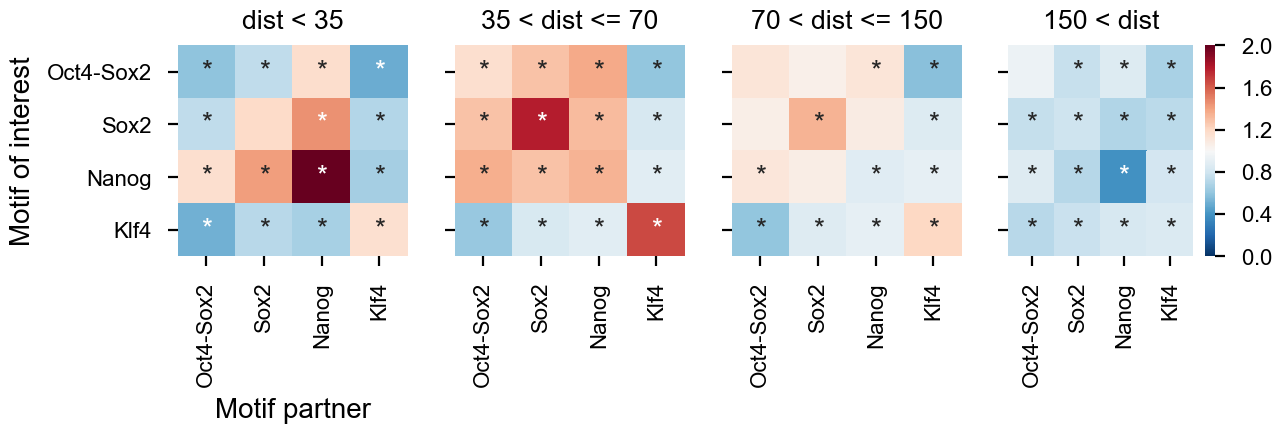

In [34]:
# subsets = ['center_diff <= 35', 'center_diff > 35', 'center_diff > 70']
subsets = dist_subsets
fig,axes = plt.subplots(1, len(subsets), 
                        figsize=get_figsize(0.25*len(subsets), .8/len(subsets)), 
                        sharey=True)
# dfs = dfi_subset.query('match_weighted_p > .2').query('imp_weighted_p > .2')
dfs = dfi_subset[(~dfi_subset.is_te) & (~dfi_subset.is_erv)]
for i, (subset,ax, subset_label) in enumerate(zip(subsets, axes, dist_subset_labels)):
    if i == len(subsets) - 1:
        cbar = True
    else:
        cbar = False
    coocurrence_plot(dfs, list(motifs), query_string=f"({subset}) & (center_diff_aln > 5)" , ax=ax, cbar=cbar)
    if i == 0:
        ax.set_ylabel("Motif of interest")
        ax.set_xlabel("Motif partner");
    
    ax.set_title(subset_label)
# plt.tight_layout()
fig.savefig(fdir / f'coocurrence.test.all-dist.main-motifs.pdf')

## Pairwise distance distribution

In [29]:
dfab_main = dfab[dfab.motif_pair.isin(motif_pairs)]
dfab_main['motif_pair'] = pd.Categorical(dfab_main['motif_pair'],
                                         categories=motif_pairs)

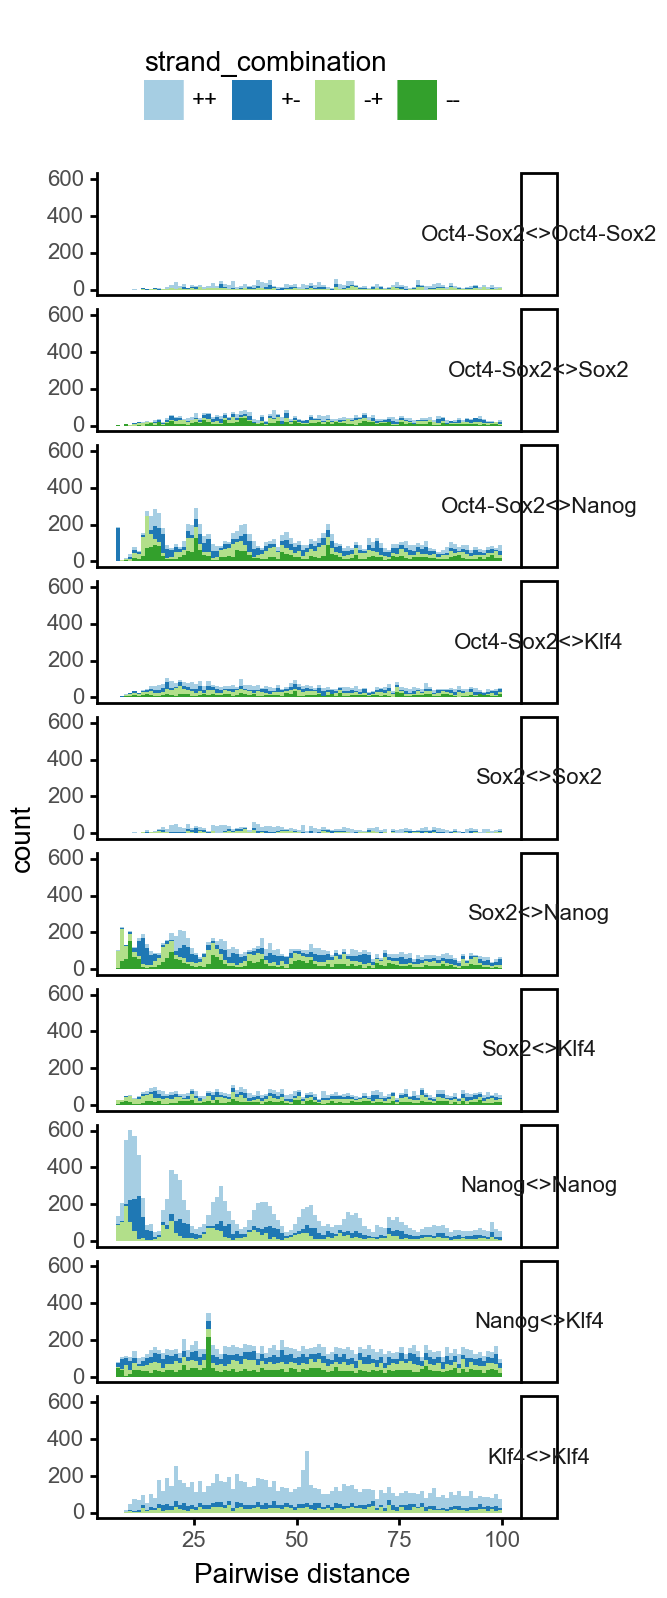

<ggplot: (-9223363275141050620)>

In [35]:
plotnine.options.figure_size = get_figsize(.4, aspect=3.1875)# (10, 10)
max_dist = 100
min_dist = 6

fig = (ggplot(aes(x='center_diff', fill='strand_combination'), dfab_main[(dfab_main.center_diff <= max_dist) & 
                                                                    (dfab_main.center_diff > min_dist)]) + 
 geom_histogram(breaks=np.arange(min_dist, max_dist + 1)) + 
 facet_grid("motif_pair~ .") +
 theme_classic(base_size=10, base_family='Arial') + 
 theme(strip_text = element_text(rotation=0), legend_position='top') + 
 xlim([min_dist, max_dist]) + 
 # ylim([0, 1000]) +
 xlab("Pairwise distance") + 
 scale_fill_brewer(type='qual', palette=3))
fig.save(fdir / 'histogram.center_diff.main-4-motifs.imp>.2,match>.0.pdf')
fig

## Individual plots

In [143]:
# Generate all spacing plots
individual_plots = {}
for motif_pair_name in pair_names:
    plotnine.options.figure_size = get_figsize(.3, aspect=2/10*4)
    max_dist = 100
    min_dist = 0
    df = dfab[(dfab.center_diff <= max_dist) & 
              (dfab.motif_pair == motif_pair_name)]
    if len(df) == 0:
        continue
    fig = (ggplot(aes(x='center_diff', fill='strand_combination'), df) + 
     # Spacing vertical lines
     geom_vline(xintercept=10, alpha=0.1) + 
     geom_vline(xintercept=20, alpha=0.1) + 
     geom_vline(xintercept=30, alpha=0.1) + 
     geom_vline(xintercept=40, alpha=0.1) + 
     # plot
     geom_histogram(breaks=np.arange(min_dist, max_dist + 1)) + 
     facet_grid("strand_combination~.") + 
     # Theme, labels, colors
     theme_classic(base_size=10, base_family='Arial') + 
     theme(strip_text = element_text(rotation=0), legend_position='top') + 
     xlim([min_dist, max_dist]) + 
     xlab("Pairwise distance") +
     ggtitle(motif_pair_name) + 
     scale_fill_brewer(type='qual', palette=3))
    
    # Save
    fig.save(fdir_individual / f'{motif_pair_name}.pdf')
    individual_plots[motif_pair_name] = fig

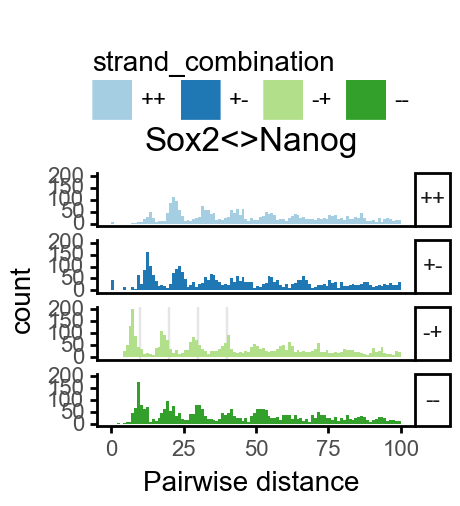

<ggplot: (-9223363287224432780)>

In [383]:
individual_plots['Sox2<>Nanog']

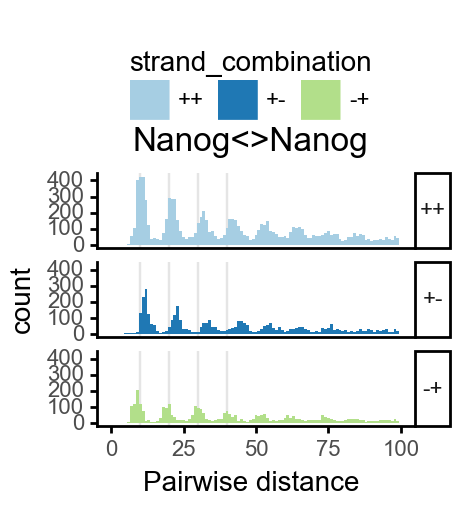

<ggplot: (-9223363277389710634)>

In [270]:
individual_plots['Nanog<>Nanog']

## Raw data + spacing

In [9]:
from basepair.exp.chipnexus.spacing import remove_edge_instances, get_motif_pairs, motif_pair_dfi
from basepair.stats import smooth_gam, smooth_lowess

Using TensorFlow backend.


In [14]:
pairs = get_motif_pairs(motifs)
motif_pairs = [k + "<>" + v for k,v in pairs]

In [15]:
# create motif pairs
# dfab = pd.concat([motif_pair_dfi(dfi_subset, pair).assign(motif_pair="<>".join(pair)) for pair in pairs], axis=0)

In [1]:
# dfab = pd.read_csv(f"{model_dir}/deeplift/dfab.csv.gz")

In [26]:
dfabm = dfab[(dfab.motif_pair == 'Nanog<>Nanog') & (dfab.strand_combination == '++')]

In [34]:
paper_config()

In [216]:
def smooth_gam(x, y, n_splines=100, lam=None):
    from pygam import ExpectileGAM, LinearGAM, s, f
    gam = LinearGAM(s(0, n_splines=n_splines)).gridsearch(x, y, lam=lam)
    # gam = ExpectileGAM(s(0, n_splines=n_splines), expectile=0.5, lam=lam).gridsearch(x.values.reshape((-1,1)), y)
    XX = gam.generate_X_grid(term=0)
    confi = gam.confidence_intervals(XX)
    # confi = gam.prediction_intervals(XX)
    ym = gam.predict_mu(XX)
    return XX[:, 0], ym, confi

In [238]:
profile_mapping

{'Oct4-Sox2': 'Oct4',
 'Oct4': 'Oct4',
 'Sox2': 'Sox2',
 'Nanog': 'Nanog',
 'Klf4': 'Klf4',
 'Essrb': 'Oct4'}

In [8]:
# TODO - run it only for the Nanog motif 

In [ ]:
for i, motif_pair in enumerate(pairs):
    same_motif = motif_pair[0] == motif_pair[1]
    if same_motif:
        fig, axes = plt.subplots(3, 1, figsize=get_figsize(.25, 2), 
                                 sharex=True, 
                                 sharey=True,
                                 gridspec_kw=dict(wspace=0, hspace=0))
    else:
        fig, axes = plt.subplots(4, 2, figsize=get_figsize(.5, 2/3*2), 
                                 sharex=True, 
                                 sharey=True,
                                 gridspec_kw=dict(wspace=0, hspace=0))

    motif_pair_name = '<>'.join(motif_pair)

    for j, strand_combination in enumerate(['++', '+-', '-+', '--']):
        dfabm = dfab[(dfab.motif_pair == motif_pair_name) & (dfab.strand_combination == strand_combination)]

        if len(dfabm) == 0:
            continue

        xmax = 100
        x = dfabm[dfabm.center_diff<xmax].center_diff.values
        for k in range(2):
            last_k = k == 1 or same_motif
            if same_motif and k == 1:
                continue
            if same_motif:
                ax = axes[j]
                tf = profile_mapping[motif_pair[0]]
                y = np.log(1+(dfabm[dfabm.center_diff<xmax][f'{tf}/profile_counts_max_ref_y'].values + 
                              dfabm[dfabm.center_diff<xmax][f'{tf}/profile_counts_max_ref_x'].values))
            else:
                ax = axes[j, k]
                tf = profile_mapping[motif_pair[k]]
                y = np.log(1+dfabm[dfabm.center_diff<xmax][f'{tf}/profile_counts_max_ref_x'].values)

            xm,ym, ci = smooth_gam(x[:, np.newaxis], y, n_splines=xmax//2, lam=np.logspace(1, 6, 11))

            ax.scatter(x, y, alpha=0.1, s=1);
            cmap = plt.get_cmap("tab10")
            color = cmap(0)
            ax.plot(xm, ym, color=color);
            if ci is not None:
                ax.fill_between(xm, ci[:, 0], ci[:, 1], alpha=0.4, color=color);
            # plt.xlim([5, 100])
            if last_k:
                ax.set_xlabel("Motif distance")
            if j == 1 and k == 0:
                ax.set_ylabel("Max profile value")
            if j == 0:
                ax.set_title(motif_pair[k])
            if last_k:
                ax.text(1, 1,strand_combination,
                     horizontalalignment='right',
                     verticalalignment='top',
                     transform = ax.transAxes)
            sns.despine(top=True, right=True)
        fig.savefig(fdir_individual_w_chipnexus / f'{motif_pair_name}.pdf')